# <center> Deep Learning Project:

> - __Ahmed Abdelazeem__ (m20210433)
> - __Omar Jarir__ (m20201378)  
> - __Chung-Ting Huang__ (m20210437) 

***

- __The objective of this notebook is to perform hyperparameters tuning:__
- Some references:
   - https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model/amp
   - https://keras.io/guides/keras_tuner/getting_started/
   - https://keras.io/api/utils/serialization_utils/
   - https://www.tensorflow.org/tutorials/keras/keras_tuner
   - https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

In [42]:
                # !pip install keras-tuner --upgrade
# !pip install -q -U keras-tuner
#!pip install findspark
#!pip install tensorflow-addons

In [43]:
import time
t1 = time.perf_counter()

***

- __Importing the necessary libraries 📚:__

In [103]:
import numpy as np
import random as python_random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras 
import keras_tuner as kt
import keras.backend as K
import tensorflow_addons as tfa

In [162]:
from keras.models import Model, Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau 
from keras import optimizers

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif 
from sklearn.utils import class_weight

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import IPython

In [46]:
import warnings
warnings.filterwarnings("ignore")

In [47]:
SEED = 2022

Fixing the random number seed to ensure that the results are reproducible.

In [48]:
session = K.get_session()

np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

- __Helper functions:__

In [49]:
# Function to create dataframe with metrics

def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
    train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain, average='macro'),
                metricsObj.f1_score(yTrain, yPredTrain, average='macro'),
                metricsObj.roc_auc_score(yTrain, yPredTrain),    
                ]
    test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest, average='macro'),
               metricsObj.f1_score(yTest, yPredTest, average='macro'),
               metricsObj.roc_auc_score(yTest, yPredTest), 
               ]
    resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results}, index=measures_list)
    return resultsDF

In [50]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [51]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

In [145]:
def MutualInfoScores(X, y):    
    mi = pd.Series(mutual_info_classif(X, y))
    mi /= mi.max()
    mi.index = X.columns
    mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
    plt.title("Feature univariate score")
    plt.ylabel('Mutual Information')
    plt.show();
    return mi

In [150]:
def FTestScores(X, y):
    f_scores = pd.Series(-np.log10(f_classif(X, y)[1]))
    f_scores /= f_scores.max()
    f_scores.index = X.columns
    f_scores = f_scores.sort_values(ascending=False)
    f_scores.plot.bar(figsize=(20,6))
    plt.title("Feature univariate score")
    plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
    plt.show()
    return f_scores

In [107]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [137]:
def remove_correlated(X):
    corr = X.corr()
    i = 1
    for (index, row) in corr.iterrows():
        for col in corr.columns[i:]:
            if row[col] > 0.9:
                print(f"{index} vs. {col} are highly correlated {row[col]}")
        i += 1
        # Select upper triangle of correlation matrix
    corr_matrix = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    # Find features with correlation greater than 0.9
    correlated_cols = [c for c in corr_matrix.columns if any(corr_matrix[c] > 0.9)]
    # Drop correlated columns
    return correlated_cols

***

- __Loading the dataset:__

In [55]:
ds= pd.read_csv("data.csv")

In [56]:
ds.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [57]:
# Checking the shape of the dataset:

ds.shape

(6819, 96)

In [58]:
# We can see that our dataset does not contain any duplicates.

ds.duplicated().sum()

0

In [59]:
# Checking the type of the columns:

ds.dtypes

Bankrupt?                                                     int64
 ROA(C) before interest and depreciation before interest    float64
 ROA(A) before interest and % after tax                     float64
 ROA(B) before interest and depreciation after tax          float64
 Operating Gross Margin                                     float64
                                                             ...   
 Liability to Equity                                        float64
 Degree of Financial Leverage (DFL)                         float64
 Interest Coverage Ratio (Interest expense to EBIT)         float64
 Net Income Flag                                              int64
 Equity to Liability                                        float64
Length: 96, dtype: object

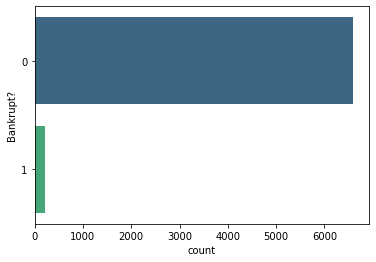

In [60]:
# Checking that the target distribution is imbalanced.

sns.countplot(y='Bankrupt?', data = ds, palette='viridis', orient = 'h');

In [61]:
ds["Bankrupt?"].value_counts(normalize=True)

0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64

In [62]:
# MutualInfoScores(ds.drop(columns="Bankrupt?"), ds["Bankrupt?"])

In [133]:
X = ds.copy(deep=True)

y = X["Bankrupt?"]
X = X.drop(columns=["Bankrupt?"])

### Splitting the dataset:

In [134]:
# Split the dataset intro train and test sets.

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.3,
                                   shuffle =True, stratify=y, random_state=SEED)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.3,
                                                   shuffle = True, stratify=y_train, random_state=SEED)

### Correlation

In [139]:
correlated_cols = remove_correlated(x_train)
x_train = x_train.drop(columns=correlated_cols)
x_val = x_val.drop(columns=correlated_cols)
x_test = x_test.drop(columns=correlated_cols)

 ROA(C) before interest and depreciation before interest vs.  ROA(A) before interest and % after tax are highly correlated 0.9446419463916639
 ROA(C) before interest and depreciation before interest vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.9864245462264032
 ROA(A) before interest and % after tax vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.9615395188598046
 ROA(A) before interest and % after tax vs.  Net Income to Total Assets are highly correlated 0.9552847017108241
 ROA(B) before interest and depreciation after tax vs.  Net Income to Total Assets are highly correlated 0.911624147935095
 Operating Gross Margin vs.  Realized Sales Gross Margin are highly correlated 0.9994220651059769
 Operating Gross Margin vs.  Gross Profit to Sales are highly correlated 0.9999999904240435
 Realized Sales Gross Margin vs.  Gross Profit to Sales are highly correlated 0.9994219264950949
 Pre-tax net Interest Rate vs.  After-tax net 

### Dealing with outliers:

In [140]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(3341, 77)
(2046, 77)
(1432, 77)


In [66]:
# x_train = removeOutliers(x_train, colList=x_train.columns , lowPercentile=0.01, highPercentile=0.99, verbose=False)
# x_val = removeOutliers(x_val, colList=x_val.columns , lowPercentile=0.01, highPercentile=0.99, verbose=False)
# x_test = removeOutliers(x_test, colList=x_test.columns , lowPercentile=0.01, highPercentile=0.99, verbose=False)

In [141]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(3341, 77)
(2046, 77)
(1432, 77)


In [142]:
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.967674
1    0.032326
Name: Bankrupt?, dtype: float64
0    0.967742
1    0.032258
Name: Bankrupt?, dtype: float64
0    0.967877
1    0.032123
Name: Bankrupt?, dtype: float64


In [69]:
# selector = SelectKBest(f_classif, k=4)
# selector.fit(X_train, y_train)
# scores = -np.log10(selector.pvalues_)
# scores /= scores.max()

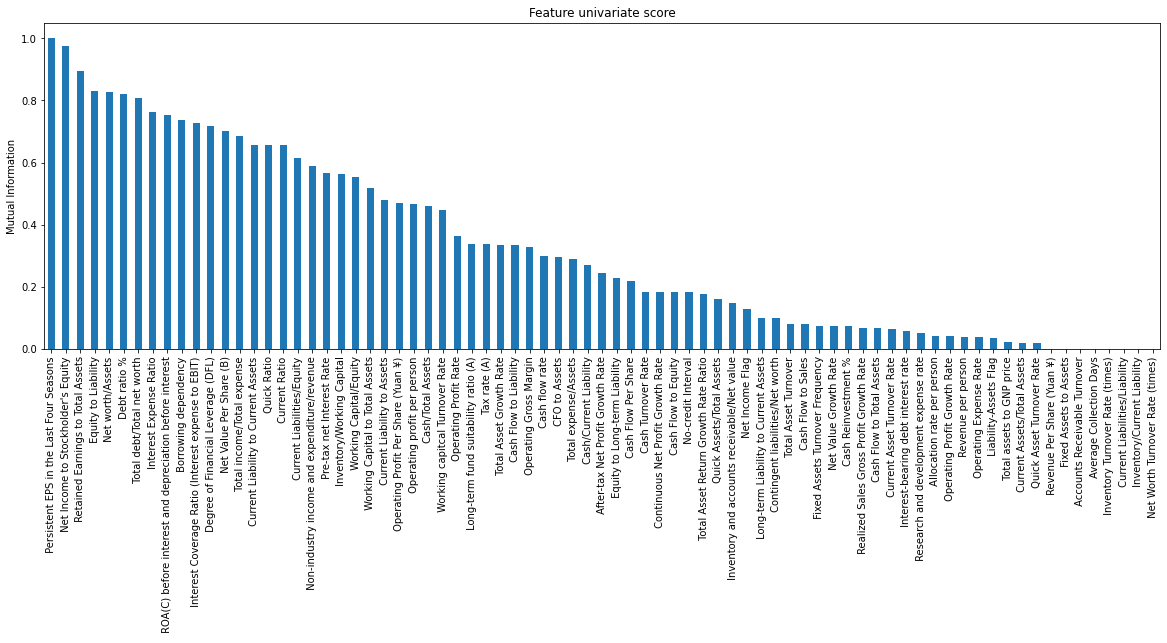

In [143]:
MutualInfoScores(x_train, y_train)

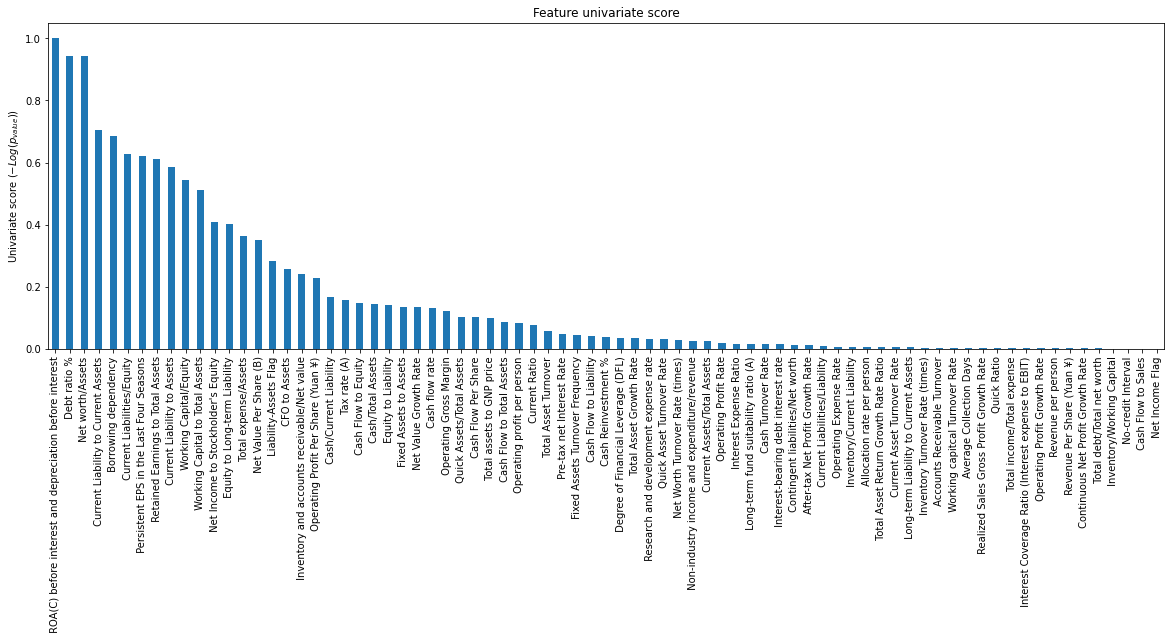

 ROA(C) before interest and depreciation before interest    1.000000
 Debt ratio %                                               0.942312
 Net worth/Assets                                           0.942312
 Current Liability to Current Assets                        0.704320
 Borrowing dependency                                       0.686083
 Current Liabilities/Equity                                 0.628991
 Persistent EPS in the Last Four Seasons                    0.621427
 Retained Earnings to Total Assets                          0.612668
 Current Liability to Assets                                0.584177
 Working Capital/Equity                                     0.544025
 Working Capital to Total Assets                            0.511760
 Net Income to Stockholder's Equity                         0.407750
 Equity to Long-term Liability                              0.403083
 Total expense/Assets                                       0.362626
 Net Value Per Share (B)          

In [151]:
f_scores = FTestScores(x_train, y_train)
f_scores.loc[f_scores > 0.2]

- The figure above shows that the number of features to select is equal to 24,because they have a value superior than 0.2

In [72]:
# MutualInfoScores(x_train, y_train)

In [152]:
selector = SelectKBest(f_classif, k=len(f_scores.loc[f_scores > 0.2]))

# selecting the features:
selector.fit(x_train, y_train)

kept_columns = list(x_train.columns[selector.get_support()]) 

In [153]:
kept_columns

[' ROA(C) before interest and depreciation before interest',
 ' Net Value Per Share (B)',
 ' Persistent EPS in the Last Four Seasons',
 ' Operating Profit Per Share (Yuan ¥)',
 ' Debt ratio %',
 ' Net worth/Assets',
 ' Borrowing dependency',
 ' Inventory and accounts receivable/Net value',
 ' Working Capital to Total Assets',
 ' Current Liability to Assets',
 ' Working Capital/Equity',
 ' Current Liabilities/Equity',
 ' Retained Earnings to Total Assets',
 ' Total expense/Assets',
 ' Equity to Long-term Liability',
 ' CFO to Assets',
 ' Current Liability to Current Assets',
 ' Liability-Assets Flag',
 " Net Income to Stockholder's Equity"]

In [154]:
x_train = x_train[kept_columns]
x_val = x_val[kept_columns]
x_test = x_test[kept_columns]

# Data Pre-processing:

In [76]:
# X = ds.copy(deep=True)

# y = X["Bankrupt?"]
# X = X.drop(columns=["Bankrupt?"])

## Data Normalization:

In [155]:
# We use the standard scaler in order to normalize the data:

scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train) 
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Hyper parameters tuning:

__Using Keras tuner:__

In [156]:
ClassWeights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train), y=y_train)))
ClassWeights

{0: 0.5167027528611197, 1: 15.467592592592593}

In [157]:
EarlyStop = EarlyStopping(monitor='val_f1', patience=3, verbose=0)

CallBacksList = [EarlyStop,]  

In [223]:
class MyHyperModel(kt.HyperModel):
    def __init__(self, k=3):
        self.k = k

    def build(self ,hp):

        hp_units_1 = hp.Choice("Layer 1", [64, 128, 256])
        hp_units_2 = hp.Choice("Layer 2", [16, 32]) # 64
        hp_units_3 = hp.Choice("Layer 3", [4, 8, 16]) # 32, 64, 16 
        hp_activation = hp.Choice("activation", ["relu", "tanh"])
        hp_kernel_initializer = hp.Choice("kernel_initializer", ["glorot_uniform", "glorot_normal"])
        hp_learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3)  
        hp_loss = hp.Choice("loss_type", ["BC", "FL"])
        hp_gamma = hp.Choice("Gamma", [0.0, 0.5, 1.0, 2.0])
        hp_dropout = hp.Choice("rate", [0.2, 0.35, 0.5])
        
        model = Sequential()
    
        model.add(layers.Dense(units = hp_units_1,
                        kernel_initializer = hp_kernel_initializer,
                        kernel_regularizer = tf.keras.regularizers.L2(0.1),
                        activation = hp_activation,
                        input_dim = x_train.shape[-1]   
                           )) 
    
        # Tune whether to use dropout.
        if hp.Boolean("Dropout 1"):
            model.add(layers.Dropout(rate=hp_dropout))
    
        model.add(layers.Dense(units = hp_units_2, 
                            kernel_initializer = hp_kernel_initializer,    
                            activation = hp_activation))
            
        if hp.Boolean("Dropout 2"):
            model.add(layers.Dropout(rate=hp_dropout))
            
        model.add(layers.Dense(units = hp_units_3, 
                            kernel_initializer = hp_kernel_initializer,    
                            activation = hp_activation))
            
        if hp.Boolean("Dropout 3"):
            model.add(layers.Dropout(rate=hp_dropout))
            
        model.add(layers.Dense(units=1, 
                            kernel_initializer = hp_kernel_initializer,
                            activation="sigmoid"))
            
        if hp_loss == "BC":
            with hp.conditional_scope("loss_type", ["BC"]):
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                        loss = tf.keras.losses.BinaryCrossentropy(),
                        metrics= [tf.keras.metrics.Accuracy(), tf.keras.metrics.AUC(), 
                                  tf.keras.metrics.Recall(), f1])
        if hp_loss == "FL":
            with hp.conditional_scope("loss_type", ["FL"]):
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                        loss = tf.keras.losses.BinaryFocalCrossentropy(gamma = hp_gamma), 
                        metrics= [tf.keras.metrics.Accuracy(), tf.keras.metrics.AUC(), 
                                  tf.keras.metrics.Recall(), f1])
    
        return model

    def kfold_split(self, x, y):
        x = np.array(x)
        y = np.array(y)
        kfold = StratifiedKFold(n_splits=self.k)
        x_train, x_val, y_train, y_val = [], [], [], []
        for train_index, val_index in kfold.split(x, y):
            x_train.append(x[train_index])
            x_val.append(x[val_index])
            # Need to use y directly because y_train is Series
            y_train.append(y[train_index])
            y_val.append(y[val_index])
        return x_train, x_val, y_train, y_val


    def fit(self, hp, model, x, y, **kwargs):
        hp_batch_size = hp.Choice("batch_size", [16, 32, 64])
        if hp.Boolean("normalize"):
            x = layers.Normalization()(x)
        f1_scores = np.zeros(self.k)
        x_train, x_val, y_train, y_val = self.kfold_split(x, y)
        for i in range(self.k):
            hist = model.fit(
                x_train[i],
                y_train[i],
                # Tune whether to shuffle the data in each epoch.
                shuffle=hp.Boolean("shuffle"),
                validation_data=(x_val[i], y_val[i]),
                batch_size = hp_batch_size,
                class_weight = ClassWeights,
                **kwargs,
            )
            f1_scores[i] = hist.history['val_f1'][-1]

        return {'val_f1': f1_scores[i].mean()}

In [224]:
tuner = kt.BayesianOptimization(
    hypermodel = MyHyperModel(),
    objective = kt.Objective("val_f1", direction="max"), 
    seed = SEED,
    max_trials = 200,
    overwrite=True,
    directory = 'Deep_learning_project',
    project_name = "Default_predictions"
)

In [225]:
tuner.search(x_train, y_train,
             epochs = 100,
             verbose = 2,
             initial_epoch = 0,
             callbacks = CallBacksList,
             use_multiprocessing = True,
            )

Trial 1 Complete [00h 00m 20s]
val_f1: 0.19142858684062958

Best val_f1 So Far: 0.19142858684062958
Total elapsed time: 00h 00m 20s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
64                |256               |Layer 1
32                |32                |Layer 2
4                 |8                 |Layer 3
tanh              |relu              |activation
glorot_uniform    |glorot_uniform    |kernel_initializer
0.0080798         |0.00016469        |learning_rate
FL                |FL                |loss_type
0                 |2                 |Gamma
0.35              |0.35              |rate
False             |True              |Dropout 1
True              |True              |Dropout 2
True              |False             |Dropout 3
64                |16                |batch_size
True              |False             |normalize
False             |False             |shuffle

[1019 1115 1116 ... 3338 3339 3340]
<class 'numpy.ndarray'>
<class 'n

In [125]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal hyper parameters are:
The first layer: {best_hps.get("Layer 1")}. \n
The second layer: {best_hps.get("Layer 2")}. \n
The third layer: {best_hps.get("Layer 3")}. \n
The activation function: {best_hps.get("activation")}. \n
The kernel initializer: {best_hps.get("kernel_initializer")}. \n
The loss function: {best_hps.get("loss_type")}. \n  
The learning rate: {best_hps.get("learning_rate")}. \n
The batch size: {best_hps.get("batch_size")}. \n
Normalize the data: {best_hps.get("normalize")}. \n
Dropout 1: {best_hps.get("Dropout 1")}. \n
Dropout 2: {best_hps.get("Dropout 2")}. \n
Dropout 3: {best_hps.get("Dropout 3")}. \n
Shuffle: {best_hps.get("shuffle")}. \n
Gamma: {best_hps.get("Gamma")}. \n
Dropout rate: {best_hps.get("rate")} \n
""")


The hyperparameter search is complete. The optimal hyper parameters are:
The first layer: 64. 

The second layer: 32. 

The third layer: 8. 

The activation function: tanh. 

The kernel initializer: glorot_normal. 

The loss function: BC. 
  
The learning rate: 0.01. 

The batch size: 64. 

Normalize the data: True. 

Dropout 1: False. 

Dropout 2: False. 

Dropout 3: True. 

Shuffle: True. 

Gamma: 0.0. 

Dropout rate: 0.2 




In [118]:
best_model_params = MyHyperModel().build(best_hps)
best_model_params

In [119]:
best_model_params.fit(x_train,
            y_train,
            epochs = 100,
            # Tune whether to shuffle the data in each epoch.
            shuffle= True,
            validation_data = (x_val, y_val),
            batch_size = 64,
            class_weight = ClassWeights,
            callbacks = CallBacksList,
            )

Epoch 1/100
53/53 [==============================] - 2s 15ms/step - loss: 1.0155 - accuracy: 0.0000e+00 - auc_1: 0.8870 - recall_1: 0.8333 - f1: 0.2025 - val_loss: 0.4335 - val_accuracy: 0.0000e+00 - val_auc_1: 0.9017 - val_recall_1: 0.8333 - val_f1: 0.2305
Epoch 2/100
53/53 [==============================] - 0s 8ms/step - loss: 0.4410 - accuracy: 0.0000e+00 - auc_1: 0.9018 - recall_1: 0.8519 - f1: 0.2539 - val_loss: 0.6027 - val_accuracy: 0.0000e+00 - val_auc_1: 0.9094 - val_recall_1: 0.8939 - val_f1: 0.1847
Epoch 3/100
53/53 [==============================] - 0s 7ms/step - loss: 0.4645 - accuracy: 0.0000e+00 - auc_1: 0.8975 - recall_1: 0.8611 - f1: 0.2194 - val_loss: 0.5314 - val_accuracy: 0.0000e+00 - val_auc_1: 0.9086 - val_recall_1: 0.8788 - val_f1: 0.1986
Epoch 4/100
53/53 [==============================] - 0s 7ms/step - loss: 0.3800 - accuracy: 0.0000e+00 - auc_1: 0.9267 - recall_1: 0.8889 - f1: 0.2661 - val_loss: 0.2902 - val_accuracy: 0.0000e+00 - val_auc_1: 0.9072 - val_recal

In [120]:
best_model_params.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1024      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,377
Trainable params: 3,377
Non-trainable params: 0
_________________________________________________________________


In [121]:
y_pred_train = best_model_params.predict(x_train)
y_pred_test = best_model_params.predict(x_test)

In [122]:
y_pred_train = (y_pred_train>0.5).astype(int)
y_pred_test = (y_pred_test>0.5).astype(int)

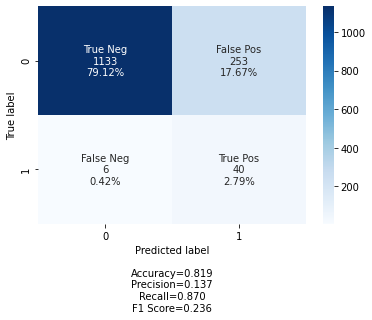

In [123]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test, y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [ ]:
# Showing the classification report:

TargetNames=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names = TargetNames))

In [ ]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

In [ ]:
# NOTICE THE DIFFERENCE BETWENN THESE TWO MODELS ONE IS BUILT USING BEST_PARAMS,
# AND ONE USING GET_BEST_PARAMS THIS IS A WIERD SITUATION.

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_model.summary()

In [ ]:
y_pred_train = best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

In [ ]:
y_pred_train = (y_pred_train>0.5).astype(int)
y_pred_test = (y_pred_test>0.5).astype(int)

In [ ]:
# Showing the confusion matrix

cm = metrics.confusion_matrix(y_test, y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

In [ ]:
# Showing the classification report:

TargetNames=["No Default", "Default"]
print(classification_report(y_test, y_pred_test, target_names = TargetNames))

In [ ]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

***

In [ ]:
t2 = time.perf_counter()
print('Time taken to run in minutes:',(t2-t1)/60.0)